# (11468) Shantanunaidu orbit determination test

#### Let's start by importing the necessary libraries

In [1]:
from grss import fit
import numpy as np
np.set_printoptions(precision=40, linewidth=np.inf)

#### We'll then retrieve the cometary state of the asteroid (from JPL SBDB) plus any nongravitational accelerations acting on it.

In [2]:
body_id = '11468'
init_sol, init_cov, nongrav_info = fit.get_sbdb_info(body_id)
de_kernel = 440

#### Next, we'll retrieve the observations from different sources (MPC, JPL, Gaia Data Releases) and prepare them for the orbit determination process.

In [3]:
add_gaia_obs = True
optical_obs_file = None
t_min_tdb = None
t_max_tdb = None
debias_lowres = True
deweight = True
eliminate = False
num_obs_per_night = 4
verbose = True
obs_df = fit.get_optical_obs(body_id, optical_obs_file, t_min_tdb, t_max_tdb, debias_lowres, deweight, eliminate, num_obs_per_night, verbose)
obs_df = fit.add_radar_obs(obs_df, t_min_tdb, t_max_tdb, verbose)
if add_gaia_obs:
    gaia_dr = 'gaiafpr'
    obs_df = fit.add_gaia_obs(obs_df, t_min_tdb, t_max_tdb, gaia_dr, verbose)

Read in 1766 observations from the MPC.
	Filtered to 1766 observations that satisfy the time range and accepted observatory constraints.
Applying Eggl et al. (2020) debiasing scheme to the observations.
	Unknown star catalog: GSC
	Unknown star catalog: UNK
	No debiasing needed for 742 observations.
	Debiased 984 observations.
	No bias information for 40 observations.
Applying Vereš et al. (2017) weighting scheme to the observations.
	Using 1488 CCD observations with station-specific weight rules.
Applying sqrt(N/4) deweighting scheme.
	Deweighted 484 observations.
Read in 308 Gaia observations from gaiafpr
	Filtered to 308 observations that satisfy the time range constraints.


#### All we need to do now is initialize the OD simulation and run the filter.

In [4]:
n_iter_max = 10
fit_sim = fit.FitSimulation(init_sol, obs_df, init_cov, n_iter_max=n_iter_max, de_kernel=de_kernel, nongrav_info=nongrav_info)

In [5]:
fit_sim.filter_lsq()

Iteration		Unweighted RMS		Weighted RMS 		Chi-squared		Reduced Chi-squared
1			 0.429			 0.566			 1329.287			 0.321
2			 0.429			 0.566			 1329.182			 0.321
Converged without rejecting outliers. Starting outlier rejection now...
3			 0.395			 0.544			 1229.607			 0.298
4			 0.395			 0.544			 1229.559			 0.298
Converged after rejecting outliers. Rejected 6 out of 2074 optical observations.


#### Let's print some summary statistics and plot some results.

In [6]:
fit_sim.print_summary()

Summary of the orbit fit calculations after postfit pass:
RMS unweighted: 0.39513926253853227
RMS weighted: 0.5444465995520997
chi-squared: 1229.558869820427
reduced chi-squared: 0.29771401206305736
square root of reduced chi-squared: 0.5456317549987879
--------------------------------------------------------------
Solution Time: MJD 57705.000 TDB = 2016-11-13 00:00:00.000 TDB
Solution Observation Arc: 16099.92 days (44.08 years)
--------------------------------------------------------------
Fitted Variable		Initial Value			Uncertainty			Fitted Value			Uncertainty			Change				Change (sigma)
e			1.66657894909e-01		2.25803501501e-09		1.66657895253e-01		2.26145158481e-09		+3.44075490322e-10		+0.152
q			2.56494181058e+00		2.93186689373e-09		2.56494181055e+00		2.94270129088e-09		-2.69020361543e-11		-0.009
tp			5.75112207046e+04		4.22648850546e-06		5.75112207052e+04		4.23707126549e-06		+5.87802787777e-07		+0.139
om			2.06375221086e+02		6.74062921881e-06		2.06375221043e+02		6.76761627073e-06	

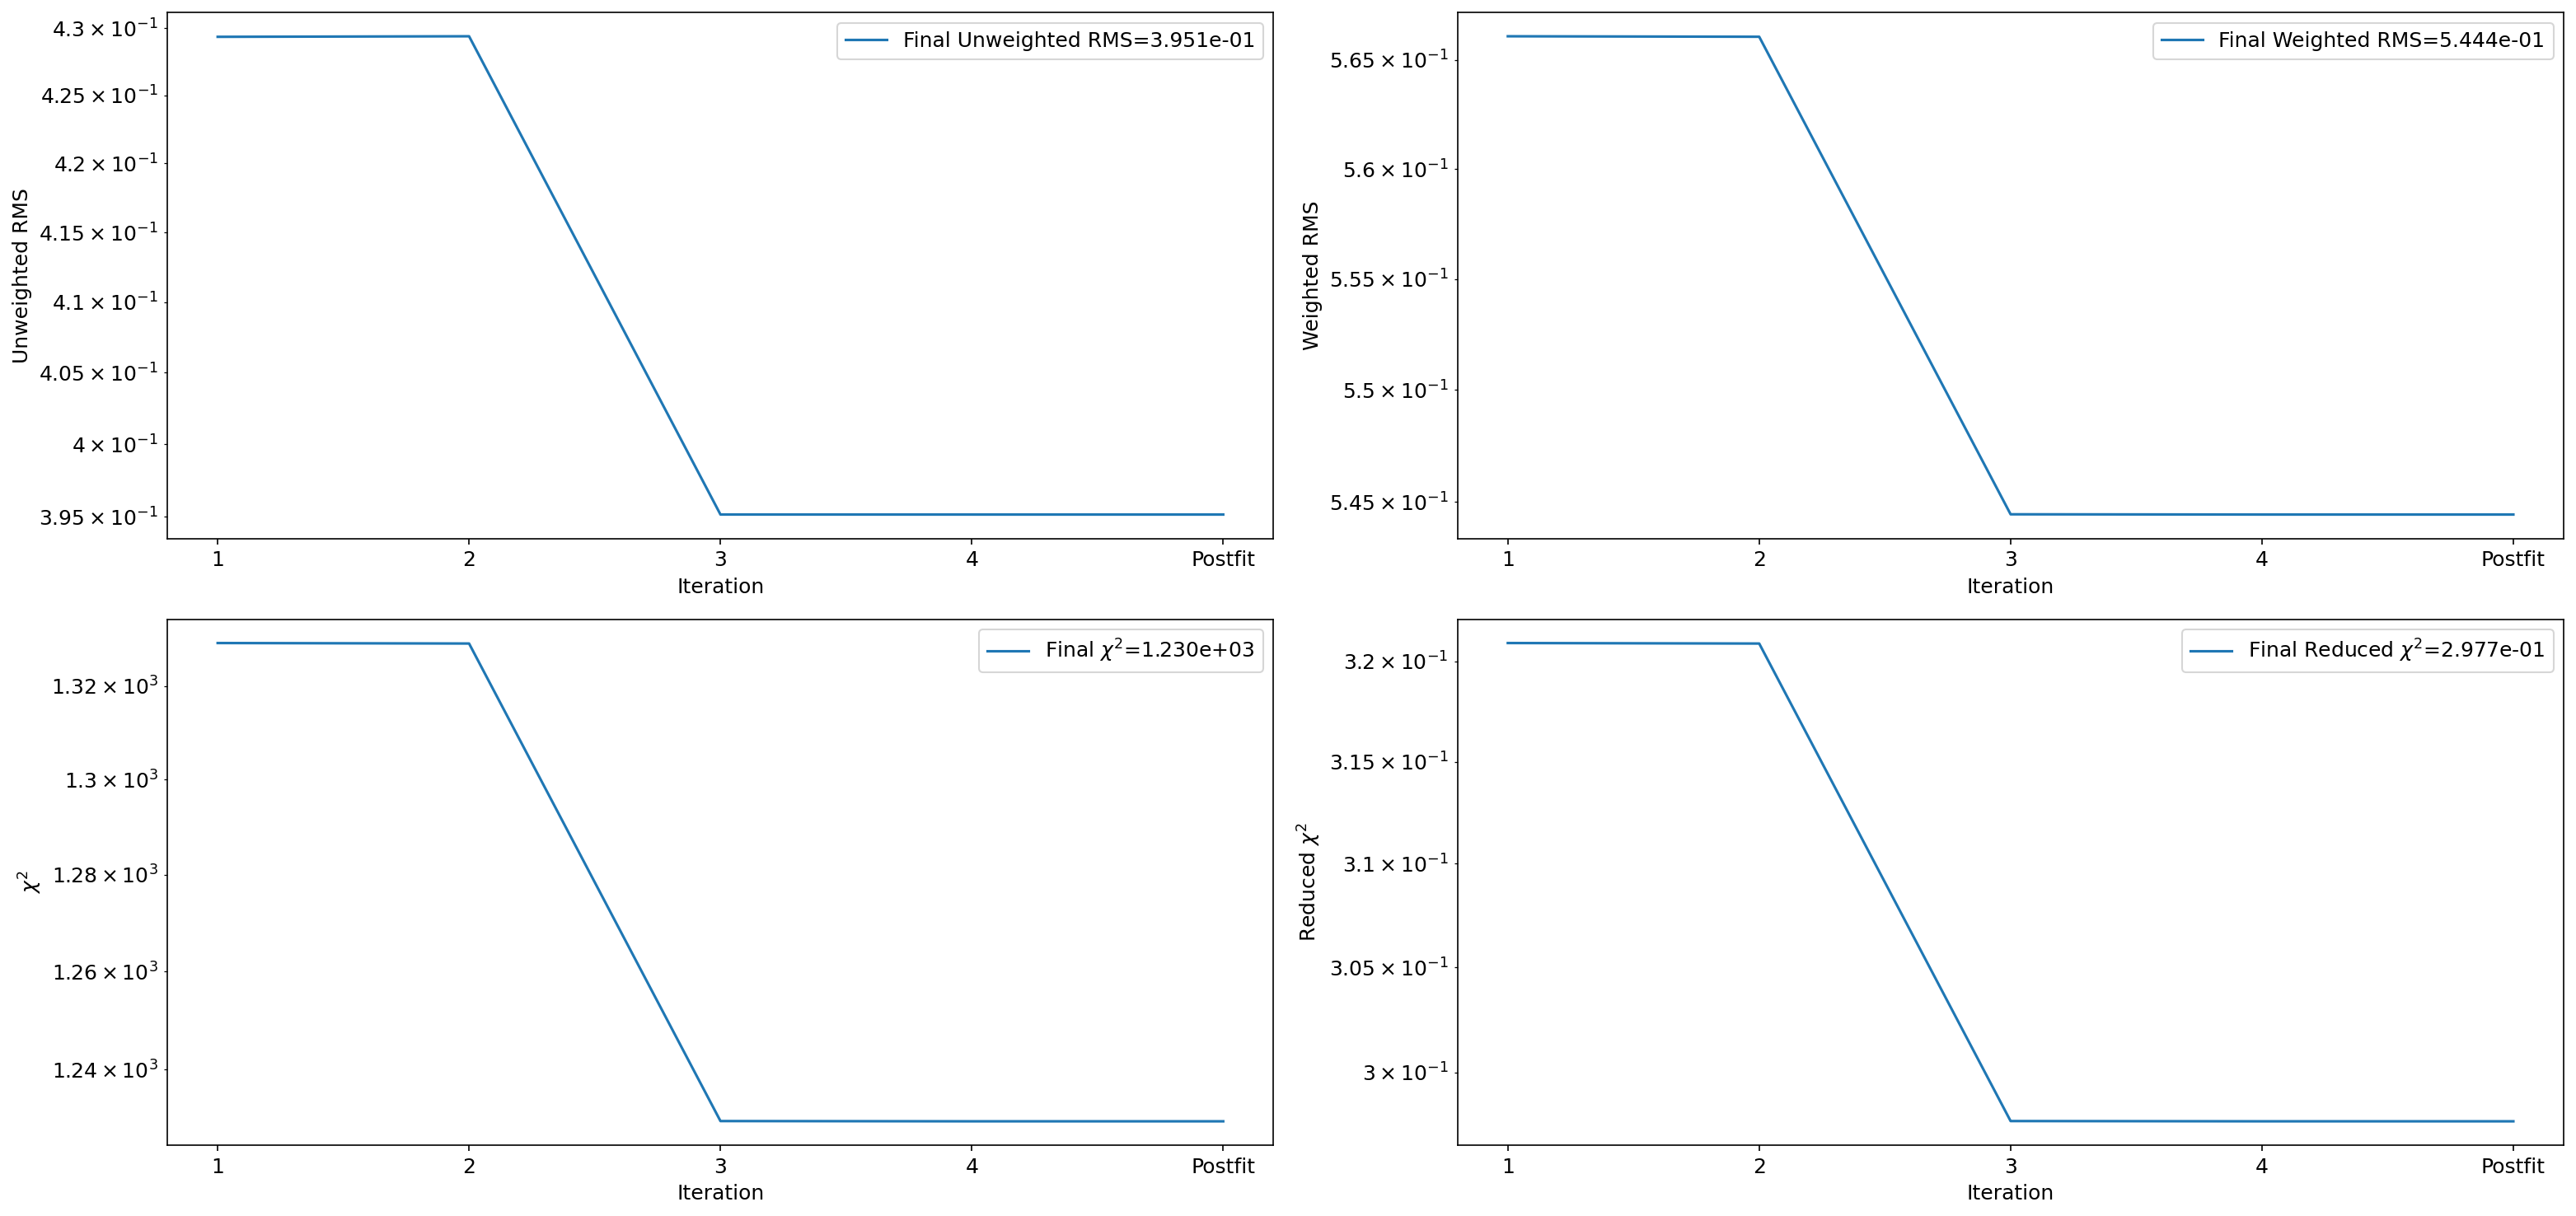

In [7]:
fit_sim.plot_summary(auto_close=True)

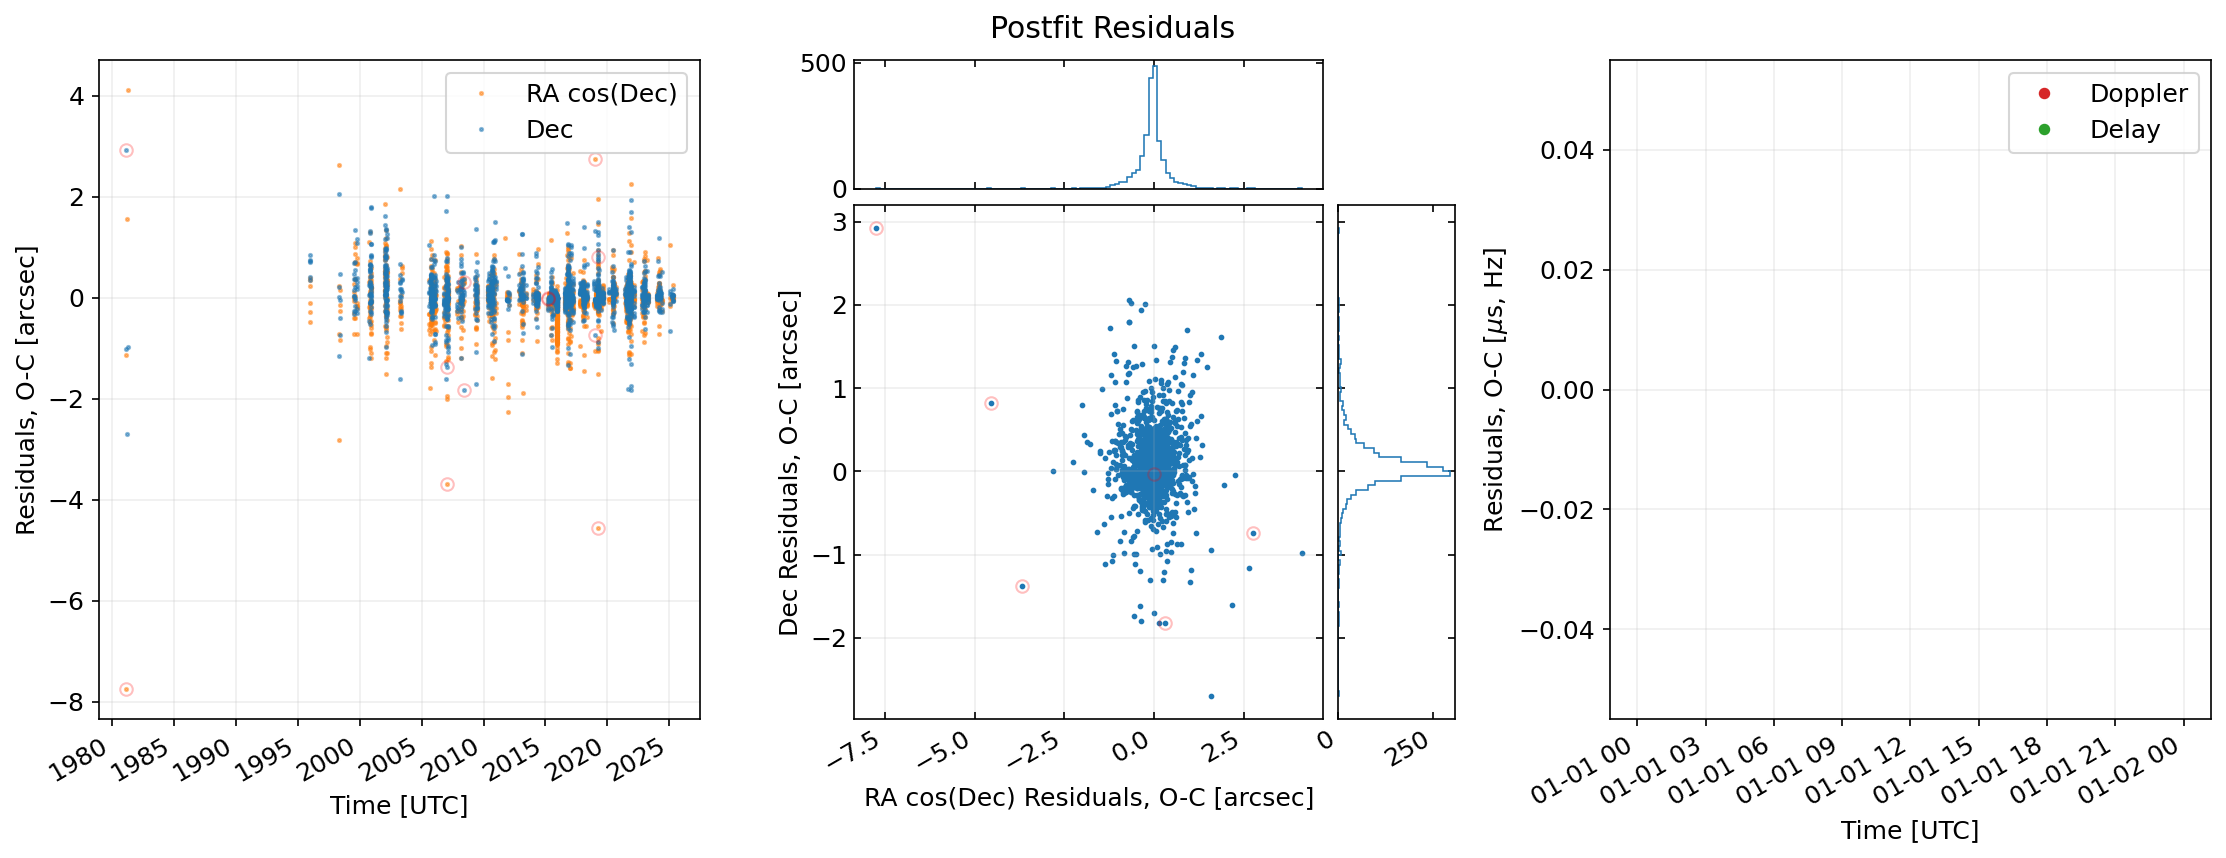

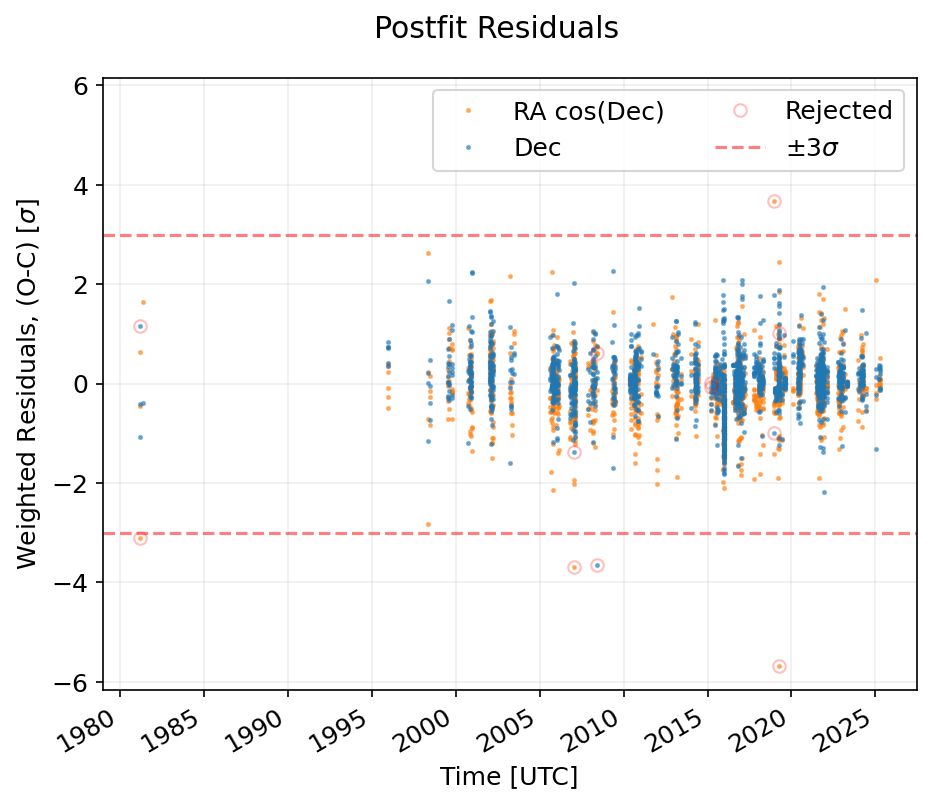

In [8]:
fit_sim.iters[-1].plot_iteration_summary(title='Postfit Residuals', auto_close=True)

In [9]:
mean_0 = np.array(list(init_sol.values())[1:])
cov_0 = init_cov
mean_f = np.array(list(fit_sim.x_nom.values()))
cov_f = fit_sim.covariance

maha_dist_f, maha_dist_0, bhattacharya, bhatt_coeff = fit.get_similarity_stats(mean_0, cov_0, mean_f, cov_f)
print(f'Mahalonobis distance between JPL and GRSS solution: {maha_dist_f:0.2f}')
print(f'Mahalonobis distance between GRSS and JPL solution: {maha_dist_0:0.2f}')
print(f'Bhattacharya distance between JPL and GRSS solution: {bhattacharya:0.4f}')
print(f'Bhattacharya coefficient between JPL and GRSS solution: {bhatt_coeff:0.4f}')

Mahalonobis distance between JPL and GRSS solution: 0.19
Mahalonobis distance between GRSS and JPL solution: 0.19
Bhattacharya distance between JPL and GRSS solution: 0.0000
Bhattacharya coefficient between JPL and GRSS solution: 1.0000


#### Finally, we'll make sure the GRSS solution is statistically consistent with the JPL SBDB solution

In [10]:
assert maha_dist_f < 5.0
assert maha_dist_0 < 5.0
assert bhattacharya < 0.10
assert bhatt_coeff > 0.90